# Importación de librerias

In [1]:
import numbers
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score
from scipy.spatial import distance
from scipy.optimize import brentq
from scipy.interpolate import interp1d

In [2]:
#Metodo para convertir ticks a segundos
def ticks_to_seconds(ticks):
    return ticks / 10000000 #10'000'000

In [3]:
"""
Método de función para encontrar el valor más cercano en un array
Parámetros
----------
array : array
value : valor que se debe de encontrar más cercano

Retorno
-------
Indice en el array y su valor respectivo en el array
"""
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

def find_fpr_and_tpr_given_a_threshold(genuine_scores, impostor_scores, threshold):
    labels = [0] * len(genuine_scores) + [1] * len(impostor_scores)
    fprs, tprs, thresholds = roc_curve(labels, genuine_scores + impostor_scores)
    idx, value = find_nearest(thresholds, threshold)
    return fprs[idx], tprs[idx], value

# Definición del método de distancia

In [4]:
"""
Método de la distancia dado dos array de vectores
Parámetros
----------
a : Vector de tiempo 1
b : Vector de tiempo 2

Retorno
-------
Distancia 'x' calculada sobre el vector a y b
"""

#Distancia
def manhattanDistance(a, b):
    return distance.cityblock(a.values, b.values)

# Definición del método de estandarización

In [5]:
"""
Método de estandarización de un punjate en distancia
Parámetros
----------
score : puntaje

Retorno
-------
Estandarización del puntaje 'x' en un valor entre 0 y 1
"""

def standardization(score, coef = 1):
    #coef = 1 / 37767187.5 #Valor de alfa
    #coef = 1 / 3.776718759
    #return 1 /( (score) *  coef + 1 )
    #return 1 / (1 + np.e**(5.05417683 * score - 5 ))
    return 1 / (1 + np.e**(0.8222310164 * score - 5 ))

#standardization(0.7802302)

# Definición del método para el cálculo del AUC

In [6]:
"""
Método para el cálculo del Area Under the Curve
Parámetros
----------
user_scores : array con los scores o distancias del usuario legítimo
impostor_scores : array con los scores o distancias de usuarios ilegítimos

Retorno
-------
AUC: area bajo la curva ROC
"""
def evaluate_AUC(genuine_scores, impostor_scores):
    #Se etiquetan los usuarios legítimos con 0 e impostores con 1
    labels = [0] * len(genuine_scores) + [1] * len(impostor_scores)
    auc_score = roc_auc_score(labels, genuine_scores + impostor_scores)
    return auc_score

In [7]:
"""
Método para el cálculo del ERR
Parámetros
----------
user_scores : array con los scores o distancias del usuario legítimo
impostor_scores : array con los scores o distancias de usuarios ilegítimos

Retorno
-------
Equal Error Rate: punto donde los missrates y los far
"""
#Primera forma de hallar el ERR
def evaluate_EER(genuine_scores, impostor_scores):
    #Se etiquetan los usuarios legítimos con 0 e impostores con 1
    labels = [0] * len(genuine_scores) + [1] * len(impostor_scores)
    
    #Se utiliza el metodo de roc_curve para hallar los fpr, tpr y umbrales
    fpr, tpr, thresholds = roc_curve(labels, genuine_scores + impostor_scores)
    
    #Variable con los False Negative Rate (FNR) - miss
    missrates = 1 - tpr
    
    #Variable con los False Positive Rate (FPR) - false alarm
    farates = fpr
    
    #Se hallan las distancias entre los FNR y FPR dado cierto umbral
    dists = missrates - farates
    
    #Listas que separan las distancias con los valores 
    #que estan más cercano al cero tanto superior como inferior
    tempList1 = dists[dists >= 0]
    tempList2 = dists[dists < 0]
    
    #Se busca el punto en la curva ROC donde se interceptan geométricamente el FNR y FPR
    #El primero que sea el cercano superior al false alarm (>=)
    #y aquel que este pegado a este en la curva pero siendo el cercano inferior (<)
    # argmin te arroja el indice el item con los menores valores
    # argmax te arroja el indice el item con los mayores valores
    #idx es una variable que almacena este índice
    
    #Indice del menor elemento del tempList1 (Lo más pegado al cero superiormente)
    idx1 = np.argmin(tempList1)
    #Sacar el indice del valor de idx1 (en tempList1), pero en la lista "dists"
    idx1, = np.where(dists == tempList1[idx1])
    
    #Indice del mayor elemento del tempList2 (Lo más pegado al cero inferiormente)
    idx2 = np.argmax(tempList2)
    #Sacar el indice del valor de idx2 (en tempList2), pero en la lista "dists"
    idx2, = np.where(dists == tempList2[idx2])
    
    #Se determina es valor de los dos puntos y ponerlo en la variable x e y
    x = [missrates[idx1], farates[idx1]]
    y = [missrates[idx2], farates[idx2]]

    #encuentrar el punto en la línea entre x e y en donde 
    #los primeros y segundos elementos del vector sean iguales.
    #Específicamente, la línea que pasa a través de x e y 
    #se define como x + a * (y-x) para todo "a"
    #Si usamos esta formula y lo igualamos, ya q x e y 
    #deben de coincidir en ese punto de la recta
    #  -> x[1] + a*(y[1]-x[1]) = x[2] + a*(y[2]-x[2])
    #lo factorizamos para determinar a
    #que seria la pendiente de la recta que construiremos
    #  -> a = (x[1] - x[2]) / (y[2]-x[2]-y[1]+x[1]) 
    
    a = ( x[0] - x[1] ) / ( y[1] - x[1] - y[0] + x[0] )
    eer = x[0] + a * ( y[0] - x[0] )
    
    return eer


#Segunda forma de hallar el EER.
def evaluate_EER_Thresh(genuine_scores, impostor_scores):
    #Se etiquetan los usuarios legítimos con 0 e impostores con 1
    labels = [0]*len(genuine_scores) + [1]*len(impostor_scores)
    
    #Se utiliza el metodo de roc_curve para hallar los fpr, tpr y umbrales
    fpr, tpr, thresholds = roc_curve(labels, genuine_scores + impostor_scores)
    
    #Se calcula el EER cuando el punto del fpr y del fpr se encuentran
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    
    thresh = interp1d(fpr, thresholds)(eer)
    return eer, thresh

# Definición del método para graficar curva ROC

In [8]:
def plotCurveROC(genuine_scores, impostor_scores, title = 'Receiver Operating Characteristic'):
    #Se etiquetan los usuarios legítimos con 0 e impostores con 1
    labels = [0] * len(genuine_scores) + [1] * len(impostor_scores)
    
    #Se utiliza el metodo de roc_curve para hallar los fpr, tpr y umbrales
    fpr, tpr, thresholds = roc_curve(labels, genuine_scores + impostor_scores)
    
    roc_auc = evaluate_AUC(genuine_scores, impostor_scores)
    
    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def plotCurveROC_Threshold(genuine_scores, impostor_scores, threshold_value , threshold_x, threshold_y , color = "green" , title = 'Receiver Operating Characteristic'):
    #Se etiquetan los usuarios legítimos con 0 e impostores con 1
    labels = [0] * len(genuine_scores) + [1] * len(impostor_scores)
    
    #Se utiliza el metodo de roc_curve para hallar los fpr, tpr y umbrales
    fpr, tpr, thresholds = roc_curve(labels, genuine_scores + impostor_scores)
    
    roc_auc = evaluate_AUC(genuine_scores, impostor_scores)
    
    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.scatter(threshold_x ,threshold_y, color = color)
    plt.text(threshold_x + 0.025, threshold_y - 0.05 , threshold_value)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Lectura de archivo y eliminación de registros no válidos
Se eliminan los registros que NO hayan escrito la palabra greyc laboratory

In [9]:
#Se define la ruta donde se encuentra el archivo y se establece la conexión
path = "./data/grey/keystroke.db"
conn = sqlite3.connect(path)

#Se hace la lectura y se almacena los datos extraídos en la variable df ("dataframe")
df = pd.read_sql_query('select * from keystroke_datas', conn, parse_dates=['date'])

#Se eliminan los registros de los usuarios que no hallan escrito la palabra 'greyc laboratory'
df.drop(df[df['password'] != 'greyc laboratory'].index, inplace = True)

#Se hace un cierre de la conexión con la base de datos SQLite
conn.close()

# Previsualización del dataset original
 El siguiente dataset contiene las siguientes columnas:
  - ppTime: vector de tiempo entre dos teclas presionadas (press - press)
  - rrTime: vector de tiempo entre dos teclas soltadas (release - release)
  - prTime: vector de tiempo entre una tecla presionada y luego soltada (press - release)
  - rpTime: vector de tiempo entre una tecla soltada y luego presionada (release - press)
  - vector: este vector concatena todos los vectores anteriores en uno solo
  - password: palabra escrita  por el usuario
  - user_id: id del usuario
  - time_to_type: tiempo que tardo en escribir la palabra
  - rawPress: data cruda extraida de las teclas presionadas
  - rawRelease: data cruda extraida de las teclas soltadas  

In [10]:
df.head(5)

,id,ppTime,rrTime,prTime,rpTime,vector,password,user_id,date,time_to_type,rawPress,rawRelease
5,6,2203168 600864 1101584 1602304 801152 2303312...,2203168 901296 500720 2503600 600864 1902736 ...,3204608 1902736 1802592 3204608 2203168 33047...,1201728 -400576 -200288 901296 -801152 901296...,2203168 600864 1101584 1602304 801152 2303312...,greyc laboratory,1,2009-03-18 08:49:09,30644064,71 633729665463844160\n82 633729665466047328\n...,71 633729665464845600\n82 633729665467048768\n...
6,7,2103024 500720 2703888 1602304 2103024 340489...,1902736 701008 2203168 1802592 2203168 310446...,3104464 1702448 3404896 2503600 3104464 41059...,901296 -500720 1502160 901296 1201728 2403456...,2103024 500720 2703888 1602304 2103024 340489...,greyc laboratory,1,2009-03-18 08:49:18,33748528,71 633729665547564544\n82 633729665549667568\n...,71 633729665548766272\n82 633729665550669008\n...
7,8,2203168 701008 1402016 1301872 2303312 330475...,2503600 801152 901296 1602304 2203168 3104464...,3304752 1902736 2103024 2303312 3204608 40057...,1402016 -400576 200288 600864 1301872 2403456...,2203168 701008 1402016 1301872 2303312 330475...,greyc laboratory,1,2009-03-18 08:49:28,29442336,71 633729665651914592\n82 633729665654117760\n...,71 633729665652715744\n82 633729665655219344\n...
8,9,2103024 701008 1902736 1702448 1602304 260374...,2303312 701008 1402016 2002880 1602304 240345...,3304752 1902736 2603744 2703888 2603744 34048...,1101584 -500720 701008 1001440 600864 1602304...,2103024 701008 1902736 1702448 1602304 260374...,greyc laboratory,1,2009-03-18 08:49:48,31545360,71 633729665853404320\n82 633729665855507344\n...,71 633729665854405760\n82 633729665856709072\n...
9,10,2002880 600864 1201728 1602304 1502160 300432...,2002880 901296 701008 1802592 1502160 2703888...,2904176 1802592 1902736 2503600 2403456 36051...,1101584 -300432 0 901296 600864 2103024 50072...,2002880 600864 1201728 1602304 1502160 300432...,greyc laboratory,1,2009-03-18 08:49:58,29642624,71 633729665954750048\n82 633729665956752928\n...,71 633729665955651344\n82 633729665957654224\n...


# Preprocesamiento de vectores de tiempo

In [11]:
#Variable temporal para almacenar los items de la columna vector
#ya que no se puede trabajar directamente con ese formato
tempData = []

#Variable con la cantidad de registros totales de la bd
n_data_rows = df.shape[0]

#Variable que tendrá la lista de columnas del dataframe
columns = ["user_id"]   

#Como existen en total 60 features de tiempo por usuario, se generará 
#los nombres de las columnas siguiento el siguiente formato 
#=> 'ft_'   +  posición del feature en el vector
for i in range(60):
    columns.append("ft_" + str(i+1))

#Por cada registro que existe en la bd se aplica lo siguente
for i in range(n_data_rows):
    
    #Se extrae el usuario de ese registro
    user_id = [df.iloc[i]["user_id"]]
    #Se extrae el tiempo de tecleo
    time_to_type = [df.iloc[i]["time_to_type"]]
    
    #Se crea el vector de tiempo
    vector = df.iloc[i]["vector"].split()      
 
    #Se verifica que la integridad del vector este OK,
    #es decir que tenga una longitud exacta de 60 items
    if(len(vector) == 60 ):
        #Se aprega el registro a la variable temporarl tempData si cumple con la condición de integridad
        tempData.append(user_id  + list(map(int, vector)))

#Se crea el dataframe y se asigna a la variable df
df = pd.DataFrame(tempData, columns = columns)

#Conversion de tick a segundos 
features = df.columns[1:61]
for i in range(len(features)):
    col = features[i]
    df[col] = df[col].apply(lambda x: ticks_to_seconds(x))

#Se liberan recursos de la variable
tempData.clear()

## Previsualización de dataset procesado
Por cada registro, se tienen las siguientes columnas
 - Los features entre el 1 y 12 corresponden al vector de tiempo ppTime
 - Los features entre el 13 y 25 corresponden al vector de tiempo rrTime
 - Los features entre el 26 y 37 corresponden al vector de tiempo prTime
 - Los features entre el 38 y 60 corresponden al vector de tiempo rpTime

In [12]:
df.head(5)

,user_id,ft_1,ft_2,ft_3,ft_4,ft_5,ft_6,ft_7,ft_8,ft_9,...,ft_51,ft_52,ft_53,ft_54,ft_55,ft_56,ft_57,ft_58,ft_59,ft_60
0,1,0.220317,0.060086,0.110158,0.160230,0.080115,0.230331,0.100144,0.260374,0.140202,...,0.330475,0.200288,0.360518,0.200288,0.280403,0.240346,0.290418,0.240346,0.230331,0.210302
1,1,0.210302,0.050072,0.270389,0.160230,0.210302,0.340490,0.140202,0.260374,0.140202,...,0.410590,0.230331,0.350504,0.210302,0.220317,0.260374,0.280403,0.260374,0.310446,0.210302
2,1,0.220317,0.070101,0.140202,0.130187,0.230331,0.330475,0.090130,0.300432,0.150216,...,0.400576,0.190274,0.390562,0.220317,0.230331,0.310446,0.260374,0.220317,0.220317,0.260374
3,1,0.210302,0.070101,0.190274,0.170245,0.160230,0.260374,0.150216,0.300432,0.150216,...,0.340490,0.270389,0.400576,0.220317,0.230331,0.240346,0.310446,0.210302,0.290418,0.240346
4,1,0.200288,0.060086,0.120173,0.160230,0.150216,0.300432,0.110158,0.290418,0.160230,...,0.360518,0.220317,0.390562,0.230331,0.260374,0.310446,0.260374,0.190274,0.250360,0.220317


# Separación de la data de entrenamiento y de prueba
Se toma de forma aleatoria el 80% de los registros de cada usuario para considerarlos como data de entrenamiento, el 10%  para la data de desarrollo del umbral y el 10 % restante para la data de prueba


La función train_test_split cuando existe un grupo impar, siempre el último subgrupo recibe el elemento extra.
Se trató de redondear el 0.80 del parámetro **train_size** debido a que cuando se trabaja con esta cantidad, arrojaba una mayor cantidad de splits con subdatasets de dev y de test desiguales. Aproximandamente **73**
![Resultados usando una proporcion de 80](./img/Proportion%20split%2080.png)

Poner 0.84 en el parámetro **train_size** permite tener menores grupos de subdatasets de dev y de test desiguales. En este solo se obtienen **4** de este tipo.
> Se debe de mantener que el dataset de dev sea lo más similar al de test.

[Link de fuente](https://cs230.stanford.edu/blog/split/)

![Resultados usando una proporcion de 84](./img/Proportion%20split%2084.png)

In [13]:
#Variable que contiene la lista de todos los usuarios de la bd
subjects = df["user_id"].unique()

#Variable del dataset de train 80%
train_users = []

#Variable del dataset de dev (desarrollo) para el calculo del umbral 10%
dev_users = []

#Variable del dataset de test 10%
test_users = []

#Separar el df en 80 / 10 / 20 respectivamente y asignarlo a sus 
for subject in subjects:
    current_user_data = df.loc[df.user_id == subject, :]
            
    #impostor_data = df.loc[df.user_id != subject, :]
    
    #Caso especial de una proporcion de 60/20/20 cuando el usuario tiene solo 5 registros
    #Para no eliminar ese registro y no lanze error 
    #Donde quedaría asi 5 -> 3 / 1 / 1

    if len(current_user_data) == 5:
        train, dev = train_test_split(current_user_data, train_size = 0.6, random_state=43, shuffle=True)
        dev , test = train_test_split(dev, train_size = 0.5, random_state=43, shuffle=True)
    
    #Caso contrario se respeta la proporcion de 80/10/10 establecida antes
    else:
        train, dev = train_test_split(current_user_data, train_size = 0.80, random_state=43, shuffle=True)
        dev , test = train_test_split(dev, train_size = 0.5, random_state=43, shuffle=True)
        
    #Se agregan a los 3 datasets los splits calculados aleatoriamente
    train_users.append(train)
    dev_users.append(dev)
    test_users.append(test)

#Se convierte los arrays en dataframes manipulables
train_users = pd.concat(train_users)
dev_users = pd.concat(dev_users)
test_users = pd.concat(test_users)

### Previsualización del dataset de entrenamiento

In [14]:
train_users

,user_id,ft_1,ft_2,ft_3,ft_4,ft_5,ft_6,ft_7,ft_8,ft_9,...,ft_51,ft_52,ft_53,ft_54,ft_55,ft_56,ft_57,ft_58,ft_59,ft_60
4797,1,0.210302,0.070101,0.260374,0.100144,0.100144,0.200288,0.050072,0.240346,0.140202,...,0.300432,0.170245,0.360518,0.220317,0.270389,0.160230,0.220317,0.170245,0.340490,0.160230
12,1,0.240346,0.060086,0.140202,0.160230,0.080115,0.210302,0.120173,0.300432,0.170245,...,0.320461,0.230331,0.430619,0.250360,0.260374,0.270389,0.270389,0.210302,0.260374,0.220317
3959,1,0.190274,0.070101,0.100144,0.080115,0.100144,0.190274,0.050072,0.260374,0.090130,...,0.260374,0.170245,0.340490,0.160230,0.290418,0.240346,0.210302,0.140202,0.250360,0.160230
6799,1,0.200288,0.070101,0.100144,0.130187,0.100144,0.210302,0.170245,0.160230,0.290418,...,0.290418,0.280403,0.240346,0.400576,0.330475,0.260374,0.260374,0.180259,0.270389,0.190274
2222,1,0.210302,0.070101,0.090130,0.120173,0.070101,0.240346,0.100144,0.210302,0.140202,...,0.340490,0.190274,0.330475,0.210302,0.310446,0.270389,0.250360,0.160230,0.300432,0.170245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7483,133,0.330475,0.240346,0.230331,0.190274,0.170245,0.220317,0.210302,0.190274,0.240346,...,0.340490,0.300432,0.310446,0.330475,0.640922,0.310446,0.330475,0.190274,0.240346,0.370533
7480,133,0.190274,0.200288,0.210302,0.210302,0.170245,0.390562,0.190274,0.230331,0.220317,...,0.470677,0.280403,0.330475,0.310446,0.280403,0.320461,0.771109,0.340490,0.250360,0.390562
7481,133,0.220317,0.180259,0.220317,0.160230,0.140202,0.260374,0.220317,0.210302,0.160230,...,0.380547,0.320461,0.300432,0.280403,0.290418,0.280403,0.520749,0.260374,0.260374,0.350504
7308,133,0.190274,0.200288,0.190274,0.200288,0.190274,0.560806,0.180259,0.120173,0.190274,...,0.640922,0.260374,0.200288,0.310446,0.330475,0.360518,0.510734,0.260374,0.300432,0.380547


### Previsualización del dataset de desarrollo

In [15]:
dev_users

,user_id,ft_1,ft_2,ft_3,ft_4,ft_5,ft_6,ft_7,ft_8,ft_9,...,ft_51,ft_52,ft_53,ft_54,ft_55,ft_56,ft_57,ft_58,ft_59,ft_60
11,1,0.220317,0.040058,0.270389,0.180259,0.170245,0.290418,0.130187,0.310446,0.120173,...,0.360518,0.230331,0.410590,0.220317,0.240346,0.250360,0.260374,0.220317,0.270389,0.210302
4789,1,0.190274,0.070101,0.150216,0.110158,0.070101,0.240346,0.100144,0.210302,0.120173,...,0.360518,0.220317,0.330475,0.210302,0.330475,0.250360,0.240346,0.170245,0.300432,0.230331
2323,1,0.220317,0.070101,0.130187,0.110158,0.080115,0.230331,0.050072,0.250360,0.150216,...,0.330475,0.180259,0.370533,0.230331,0.300432,0.290418,0.270389,0.220317,0.270389,0.250360
8,1,0.210302,0.060086,0.120173,0.170245,0.310446,0.240346,0.140202,0.350504,0.150216,...,0.320461,0.250360,0.440634,0.220317,0.240346,0.250360,0.270389,0.180259,0.260374,0.250360
0,1,0.220317,0.060086,0.110158,0.160230,0.080115,0.230331,0.100144,0.260374,0.140202,...,0.330475,0.200288,0.360518,0.200288,0.280403,0.240346,0.290418,0.240346,0.230331,0.210302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7148,132,0.210302,0.150216,0.180259,0.160230,0.160230,0.290418,0.160230,0.140202,0.190274,...,0.370533,0.260374,0.220317,0.260374,0.330475,0.230331,0.120173,0.380547,0.360518,0.290418
7359,132,0.210302,0.120173,0.160230,0.160230,0.170245,0.260374,0.140202,0.180259,0.140202,...,0.340490,0.240346,0.240346,0.220317,0.340490,0.240346,0.140202,0.550792,0.360518,1.031483
7140,132,0.230331,0.150216,0.220317,0.180259,0.200288,0.380547,0.140202,0.190274,0.170245,...,0.450648,0.250360,0.280403,0.250360,0.370533,0.270389,0.190274,0.690994,0.300432,0.410590
7314,133,0.190274,0.210302,0.560806,0.280403,0.130187,0.190274,0.140202,0.170245,0.210302,...,0.300432,0.260374,0.280403,0.330475,0.310446,0.290418,0.360518,0.240346,0.230331,0.360518


### Previsualización del dataset de prueba

In [16]:
test_users

,user_id,ft_1,ft_2,ft_3,ft_4,ft_5,ft_6,ft_7,ft_8,ft_9,...,ft_51,ft_52,ft_53,ft_54,ft_55,ft_56,ft_57,ft_58,ft_59,ft_60
6795,1,0.250360,0.040058,0.190274,0.120173,0.070101,0.220317,0.130187,0.230331,0.280403,...,0.310446,0.260374,0.340490,0.370533,0.320461,0.240346,0.290418,0.190274,0.320461,0.230331
3954,1,0.170245,0.070101,0.110158,0.090130,0.070101,0.200288,0.050072,0.230331,0.090130,...,0.280403,0.160230,0.340490,0.170245,0.280403,0.220317,0.220317,0.160230,0.260374,0.150216
6802,1,0.190274,0.070101,0.150216,0.110158,0.090130,0.220317,0.120173,0.190274,0.260374,...,0.320461,0.240346,0.290418,0.330475,0.290418,0.260374,0.230331,0.110158,0.280403,0.160230
405,1,0.160230,0.090130,0.090130,0.170245,0.090130,0.180259,0.120173,0.260374,0.140202,...,0.300432,0.230331,0.420605,0.240346,0.310446,0.260374,0.250360,0.240346,0.250360,0.230331
4791,1,0.250360,0.080115,0.210302,0.120173,0.100144,0.210302,0.120173,0.240346,0.180259,...,0.300432,0.240346,0.380547,0.250360,0.310446,0.280403,0.280403,0.170245,0.350504,0.190274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6751,132,0.200288,0.140202,0.160230,0.180259,0.160230,0.280403,0.160230,0.150216,0.210302,...,0.360518,0.280403,0.220317,0.290418,0.330475,0.260374,0.170245,0.530763,0.370533,0.340490
6754,132,0.210302,0.170245,0.190274,0.140202,0.170245,0.280403,0.190274,0.160230,0.200288,...,0.380547,0.280403,0.260374,0.290418,0.360518,0.240346,0.190274,0.430619,0.350504,0.240346
7477,133,0.210302,0.290418,0.350504,0.380547,0.120173,0.210302,0.480691,0.140202,0.260374,...,0.330475,0.580835,0.260374,0.380547,0.240346,0.350504,0.420605,0.290418,0.280403,0.390562
7313,133,0.220317,0.180259,0.170245,0.120173,0.190274,0.190274,0.210302,0.140202,0.400576,...,0.330475,0.300432,0.190274,0.500720,0.430619,0.400576,0.380547,0.270389,0.320461,0.410590


# Cálculo del vector con la media de cada usuario en el dataset de entrenamiento

In [17]:
#Se calcula la media de cada usuario agrupando el dataframe de train
groupby = train_users.groupby("user_id").mean()

#Se incluye la columna del usuario
train_users = groupby.reset_index()

### Previsualización de los vectores con la media de los usuarios

In [18]:
train_users.head(7)

,user_id,ft_1,ft_2,ft_3,ft_4,ft_5,ft_6,ft_7,ft_8,ft_9,...,ft_51,ft_52,ft_53,ft_54,ft_55,ft_56,ft_57,ft_58,ft_59,ft_60
0,1,0.199935,0.062561,0.145975,0.113457,0.091661,0.233394,0.093193,0.234926,0.156460,...,0.316573,0.200641,0.342139,0.230685,0.292185,0.257429,0.254601,0.184029,0.282170,0.200288
1,2,0.232902,0.221264,0.167944,0.147915,0.086746,0.258344,0.140743,0.182560,0.287440,...,0.335347,0.263216,0.254555,0.368232,0.242646,0.254285,0.413297,0.310176,0.319378,0.249683
2,3,0.166650,0.218006,0.361417,0.178205,0.290674,0.276937,0.208633,0.385811,0.254468,...,0.375283,0.309548,0.482745,0.365397,0.453729,0.403272,0.396596,0.372972,0.341260,0.410847
3,4,0.128079,0.274605,0.232264,0.139499,0.122457,0.169893,0.237886,0.195017,0.195544,...,0.255982,0.309217,0.267402,0.270916,0.329070,0.268281,0.205734,0.359289,0.303770,0.238940
4,5,0.089099,0.044476,0.140349,0.080852,0.181879,0.267296,0.121351,0.155665,0.226208,...,0.324879,0.194103,0.215015,0.285410,0.298959,0.153014,0.261553,0.187623,0.191894,0.216930
5,6,0.111213,0.063600,0.200288,0.162514,0.188165,0.266348,0.119119,0.288836,0.185530,...,0.353842,0.221020,0.375452,0.266699,0.320285,0.205383,0.331529,0.279349,0.274605,0.234899
6,7,0.143490,0.132280,0.156494,0.217626,0.130038,0.131831,0.137063,0.274574,0.151262,...,0.230630,0.208808,0.348411,0.231975,0.292510,0.238104,0.279805,0.249314,0.423295,0.247819


# Cálculo de las distancias con los registros del subdataset de DESARROLLO

![Calculo de distancias](./img/Calculo%20de%20distancias.png)


### Ejemplo del usuario 1

In [19]:
#Variable donde se almacenará toda la informacion calculada del usuario 1 
user_1_evaluation_dev = []

#Calculo de la media del vector del usuario 1
mean_vector= train_users.loc[train_users.user_id == 1, "ft_1":"ft_60"]

#Para cada registro del subdataset de test
for index, row in dev_users.iterrows():
    
    temp_obj = {}
    
    #user id del registro actual del subdataset de test
    current_user_id = row[0]
    
    #Vector de tiempo del registro actual del subdataset de test
    current_data = row[1:]
    
    #Actual modelo del usuario a evaluar
    temp_obj["user_model"] = 1

    #user id del registro actual
    temp_obj["user_id"] = current_user_id
    
    #Puntaje o score del modelo
    temp_obj["score"] = manhattanDistance(mean_vector, current_data)

    #Normalizacion del score
    temp_obj["std_score"] = standardization(temp_obj["score"])
    
    #Variable que indica si el registro deberia de ser clasificado como geniono o impostor
    if current_user_id == 1:
        temp_obj["y_test"] = "genuine"
    else:
        temp_obj["y_test"] = "impostor"
    
    user_1_evaluation_dev.append(temp_obj)
    
user_1_evaluation_dev = pd.DataFrame(user_1_evaluation_dev)

### Puntaje de los registros del subdataset de desarrollo usando el modelo del usuario 1
 - **user_model:** modelo del usuario empleado para sacar el score
 - **user_id:** usuario del registro evaluado
 - **score:** puntuación que le dió el modelo
 - **std_score:** puntuación normalizada
 - **y_test:** cuando el user_model y user_id **(1)** coinciden, entonces se usó un registro de usuario considerado genuino; caso contrario, es de un impostor

In [20]:
user_1_evaluation_dev

,user_model,user_id,score,std_score,y_test
0,1,1.0,2.641681,0.944166,genuine
1,1,1.0,1.425579,0.978707,genuine
2,1,1.0,0.969865,0.985263,genuine
3,1,1.0,2.587957,0.946450,genuine
4,1,1.0,1.620683,0.975094,genuine
...,...,...,...,...,...
737,1,132.0,4.592250,0.772786,impostor
738,1,132.0,7.772824,0.199239,impostor
739,1,132.0,6.435607,0.427623,impostor
740,1,133.0,6.146250,0.486594,impostor


### Cálculo usando los modelos de todos los usuarios

In [21]:
users_evaluation_dev = []

#Se hace el cálculo para cada usuario
for subject in subjects:
    
    #Media del vector del usuario actual
    mean_vector= train_users.loc[train_users.user_id == subject, "ft_1":"ft_60"]
    
    #Para cada registro del subdataset de test
    for index, row in dev_users.iterrows():

        temp_obj = {}

        #userid del del registro actual del subdataset de test
        current_user_id = row[0]

        #Vector de tiempo del registro actual del subdataset de test
        current_data = row[1:]

        temp_obj["user_model"] = subject

        temp_obj["user_id"] = current_user_id

        temp_obj["score"] = manhattanDistance(mean_vector, current_data)
        
        temp_obj["std_score"] = standardization(temp_obj["score"])
        
        #temp_obj["std_score"] = standardizationMinMax(euclideanDistance(mean_vector, current_data))
        
        if subject == current_user_id:
            temp_obj["y_test"] = "genuine"
        else:
            temp_obj["y_test"] = "impostor"

        users_evaluation_dev.append(temp_obj)

users_evaluation_dev = pd.DataFrame(users_evaluation_dev)

### Puntaje de los registros del subdataset de test usando todos los modelos
 - **user_model:** modelo del usuario empleado para sacar el score
 - **user_id:** usuario del registro evaluado
 - **score:** puntuación que le dió el modelo
 - **std_score:** puntuación normalizada
 - **y_test:** cuando el user_model y user_id coinciden, entonces se usó un registro de usuario considerado genuino; caso contrario, es de un impostor

In [22]:
users_evaluation_dev

,user_model,user_id,score,std_score,y_test
0,1,1.0,2.641681,0.944166,genuine
1,1,1.0,1.425579,0.978707,genuine
2,1,1.0,0.969865,0.985263,genuine
3,1,1.0,2.587957,0.946450,genuine
4,1,1.0,1.620683,0.975094,genuine
...,...,...,...,...,...
98681,133,132.0,4.673035,0.760912,impostor
98682,133,132.0,8.146451,0.154692,impostor
98683,133,132.0,5.151618,0.682261,impostor
98684,133,133.0,3.648404,0.880815,genuine


In [23]:
#Obtenemos la listas de scores de los registros que deberian de catalogarse como genuinos por los modelos
genuine_scores_dev = list(users_evaluation_dev.loc[users_evaluation_dev.y_test == "genuine", "score"])

#Obtenemos la listas de scores de los registros que deberian de catalogarse como impostores por los modelos
impostor_scores_dev = list(users_evaluation_dev.loc[users_evaluation_dev.y_test == "impostor", "score"])

# Cálculo del umbral de decisión con el subdataset de DESARROLLO

Buscamos el punto en donde los falsos negativos y los falsos positivos son iguales en los modelos de manera global
![Calculo de umbral](./img/Calculo%20del%20umbral.png)

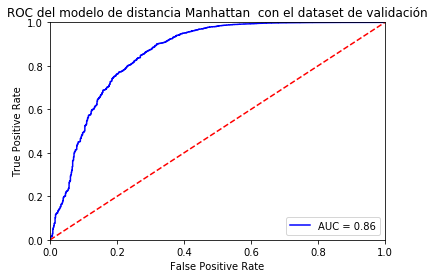

In [24]:
#Calculo del ERR y del umbral de decisión global
err_dev, thresh_dev = evaluate_EER_Thresh(genuine_scores_dev, impostor_scores_dev)

#Ploteamos la curva ROC de los umbrales
plotCurveROC ( genuine_scores_dev, impostor_scores_dev, title = "ROC del modelo de distancia Manhattan  con el dataset de validación")

### Umbral de decisión global hallado (en formato score)

In [25]:
thresh_dev

array(4.53030812)

In [26]:
'{0:.15f}'.format(standardization(thresh_dev))

'0.781604317441693'

### Respectiva tasa de error que nos daria el umbral de decisión

In [27]:
err_dev

0.21971584166974453

In [28]:
# OJO, aca se esta usando el score como umbral, si usaramos el score estandarizado, deberiamos de cambiar el sentido de la comparación
users_evaluation_dev['y_pred'] = np.where(users_evaluation_dev['score'] <= thresh_dev, 'genuine', 'impostor')

users_evaluation_dev.to_excel("./output/outputPredManhattanDev.xlsx")

#Presentamos el calculo de resultados
users_evaluation_dev

,user_model,user_id,score,std_score,y_test,y_pred
0,1,1.0,2.641681,0.944166,genuine,genuine
1,1,1.0,1.425579,0.978707,genuine,genuine
2,1,1.0,0.969865,0.985263,genuine,genuine
3,1,1.0,2.587957,0.946450,genuine,genuine
4,1,1.0,1.620683,0.975094,genuine,genuine
...,...,...,...,...,...,...
98681,133,132.0,4.673035,0.760912,impostor,impostor
98682,133,132.0,8.146451,0.154692,impostor,impostor
98683,133,132.0,5.151618,0.682261,impostor,impostor
98684,133,133.0,3.648404,0.880815,genuine,genuine


In [29]:
#Obtenemos los y_test y y_pred de nuestros resultados
y_test_dev = users_evaluation_dev.loc[:, "y_test"]
y_pred_dev = users_evaluation_dev.loc[:, "y_pred"]

### Precisión del umbral hallado con el subdataset de desarrollo

In [30]:
accuracy_score(y_test_dev, y_pred_dev)

0.7802626512372576

# Evaluación del umbral usando el subdataset de PRUEBA

In [31]:
users_evaluation_test = []

#Se hace el cálculo para cada usuario
for subject in subjects:
    
    #Media del vector del usuario actual
    mean_vector= train_users.loc[train_users.user_id == subject, "ft_1":"ft_60"]
    
    #Para cada registro del subdataset de test
    for index, row in test_users.iterrows():

        temp_obj = {}

        #userid del del registro actual del subdataset de test
        current_user_id = row[0]

        #Vector de tiempo del registro actual del subdataset de test
        current_data = row[1:]

        temp_obj["user_model"] = subject

        temp_obj["user_id"] = current_user_id

        temp_obj["score"] = manhattanDistance(mean_vector, current_data)
        
        temp_obj["std_score"] = standardization(temp_obj["score"])
        
        #temp_obj["std_score"] = standardizationMinMax(euclideanDistance(mean_vector, current_data))
        
        if subject == current_user_id:
            temp_obj["y_test"] = "genuine"
        else:
            temp_obj["y_test"] = "impostor"

        users_evaluation_test.append(temp_obj)

users_evaluation_test = pd.DataFrame(users_evaluation_test)

### Puntaje de los registros del subdataset de test usando todos los modelos
 - **user_model:** modelo del usuario empleado para sacar el score
 - **user_id:** usuario del registro evaluado
 - **score:** puntuación que le dió el modelo
 - **std_score:** puntuación normalizada
 - **y_test:** cuando el user_model y user_id coinciden, entonces se usó un registro de usuario considerado genuino; caso contrario, es de un impostor

In [32]:
# OJO, aca se esta usando el score como umbral, si usaramos el score estandarizado, deberiamos de cambiar el sentido de la comparación
users_evaluation_test['y_pred'] = np.where(users_evaluation_test['score'] <= thresh_dev, 'genuine', 'impostor')

users_evaluation_test.to_excel("./output/outputPredManhattanTest.xlsx")

#Presentamos el calculo de resultados
users_evaluation_test

,user_model,user_id,score,std_score,y_test,y_pred
0,1,1.0,1.828512,0.970589,genuine,genuine
1,1,1.0,1.622568,0.975056,genuine,genuine
2,1,1.0,1.683597,0.973806,genuine,genuine
3,1,1.0,1.903914,0.968767,genuine,genuine
4,1,1.0,1.709517,0.973257,genuine,genuine
...,...,...,...,...,...,...
108390,133,132.0,4.997713,0.709040,impostor,impostor
108391,133,132.0,4.772125,0.745776,impostor,impostor
108392,133,133.0,4.499101,0.785953,genuine,genuine
108393,133,133.0,3.955161,0.851693,genuine,genuine


In [33]:
#Obtenemos los y_test y y_pred de nuestros resultados
y_test_test = users_evaluation_test.loc[:, "y_test"]
y_pred_test = users_evaluation_test.loc[:, "y_pred"]

# Resultados
### Precisión del umbral hallado

In [34]:
accuracy_score(y_test_test, y_pred_test)

0.7861155957378108

### Curva ROC

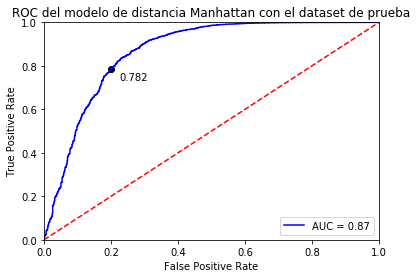

In [35]:
#Obtenemos la listas de scores de los registros que deberian de catalogarse como genuinos por los modelos
genuine_scores_test = list(users_evaluation_test.loc[users_evaluation_test.y_test == "genuine", "score"])

#Obtenemos la listas de scores de los registros que deberian de catalogarse como impostores por los modelos
impostor_scores_test = list(users_evaluation_test.loc[users_evaluation_test.y_test == "impostor", "score"])

thresh_x, thresh_y, _ = find_fpr_and_tpr_given_a_threshold(genuine_scores_test, impostor_scores_test, thresh_dev)

thresh_std = round(standardization(thresh_dev), 3)

#Ploteamos la curva ROC
plotCurveROC_Threshold( genuine_scores_test, impostor_scores_test, thresh_std, thresh_x, thresh_y, "black",  title = "ROC del modelo de distancia Manhattan con el dataset de prueba")

### TEST

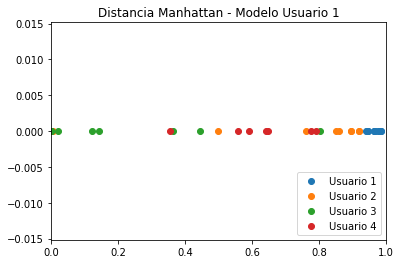

In [36]:
plt.title("Distancia Manhattan - Modelo Usuario 1")

sc1 = users_evaluation_dev.loc[(users_evaluation_dev.user_model == 1) & (users_evaluation_dev.user_id == 1), "std_score"]
sc2 = users_evaluation_dev.loc[(users_evaluation_dev.user_model == 1) & (users_evaluation_dev.user_id == 2), "std_score"]
sc3 = users_evaluation_dev.loc[(users_evaluation_dev.user_model == 1) & (users_evaluation_dev.user_id == 3), "std_score"]
sc4 = users_evaluation_dev.loc[(users_evaluation_dev.user_model == 1) & (users_evaluation_dev.user_id == 4), "std_score"]

y1 = np.zeros(len(sc1))
y2 = np.zeros(len(sc2))
y3 = np.zeros(len(sc3))
y4 = np.zeros(len(sc4))

plt.scatter(sc1, y1, label = "Usuario 1")
plt.scatter(sc2, y2, label = "Usuario 2")
plt.scatter(sc3, y3, label = "Usuario 3")
plt.scatter(sc4, y4, label = "Usuario 4")

plt.legend(loc = 'lower right')
plt.xlim([0, 1])

plt.show()

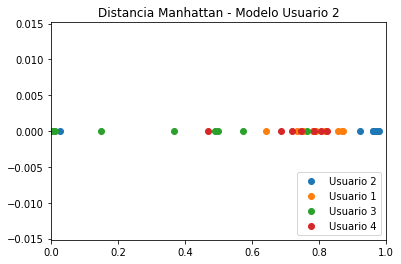

In [37]:
plt.title("Distancia Manhattan - Modelo Usuario 2")

sc1 = users_evaluation_dev.loc[(users_evaluation_dev.user_model == 2) & (users_evaluation_dev.user_id == 1), "std_score"]
sc2 = users_evaluation_dev.loc[(users_evaluation_dev.user_model == 2) & (users_evaluation_dev.user_id == 2), "std_score"]
sc3 = users_evaluation_dev.loc[(users_evaluation_dev.user_model == 2) & (users_evaluation_dev.user_id == 3), "std_score"]
sc4 = users_evaluation_dev.loc[(users_evaluation_dev.user_model == 2) & (users_evaluation_dev.user_id == 4), "std_score"]

y1 = np.zeros(len(sc1))
y2 = np.zeros(len(sc2))
y3 = np.zeros(len(sc3))
y4 = np.zeros(len(sc4))

plt.scatter(sc2, y2, label = "Usuario 2")
plt.scatter(sc1, y1, label = "Usuario 1")
plt.scatter(sc3, y3, label = "Usuario 3")
plt.scatter(sc4, y4, label = "Usuario 4")

plt.legend(loc = 'lower right')
plt.xlim([0,1])
plt.show()

In [38]:
a = users_evaluation_test.min()["score"]

'{0:.15f}'.format(a)

'0.865828333333334'

In [39]:
a = users_evaluation_test.max()["score"]

'{0:.015f}'.format(a)


'34.972510222222226'

In [40]:
a = users_evaluation_test.min()["std_score"]

'{0:.8f}'.format(a)

'0.00000000'

In [41]:
a = users_evaluation_test.max()["std_score"]

'{0:.8f}'.format(a)

'0.98645485'

In [42]:
#df2['age_bmi'] = df.age * df.bmi

In [43]:
#Generar excel
#users_evaluation.to_excel("output.xlsx")